# postprocessing_NMROM_SRPC
Notebook to postprocess DD FOM and DD NM-ROM solution data (e.g, computing errors, making plots)   
Author: Alejandro Diaz  
Date:  3/15/2024

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse as sp
import scipy.linalg as la
from time import time
from utils.Burgers2D_probgen import Burgers2D
from utils.helpers import sp_diag
from utils.domain_decomposition import DD_FOM, DDFOM_data
from utils.lsrom import assemble_snapshot_matrix, compute_bases_from_svd
from utils.nmrom import DD_NMROM, dd_rbf
from IPython.display import HTML, Image
from utils.solvers import newton_solve
import sys, os, torch
import dill as pickle

/usr/workspace/diaz64/anaconda/envs/opence-1.7.2-cuda-11.4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rc('font', size=20)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['text.usetex'] = True

In [4]:
# make directories for figures and data
data_dir = './data/'
fig_dir0 = './figures/'
for d in [data_dir, fig_dir0]:
    if not os.path.exists(d): os.mkdir(d)

## Set FOM parameters, initial condition

In [5]:
# parameters for physical domain and FD discretization
x_lim = [0, 1]
y_lim = [0, 1]
nx, ny    = 60, 60
viscosity = 1e-2

# number of subdomains in x and y directions
nsub_x, nsub_y = 4, 2
nsub = nsub_x*nsub_y

# time integration parameters
nt    = 1000
t_lim = [0, 2]
ht    = (t_lim[1]-t_lim[0])/nt

# parameter for initial condition
mu = 1.0

In [6]:
# parameterized initial conditions
def u0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

def v0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

## Initialize monolithic FOM and DD FOM

In [7]:
# initialize model
print('Initializing Burgers model...')
sys.stdout.flush()
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity)
print('Done!')

Initializing Burgers model...
Done!


In [8]:
# initialize DD FOM
ddfom = DD_FOM(fom, nsub_x, nsub_y)
ddfom.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

## Load FOM solution

In [9]:
ddfom_data = DDFOM_data(nx, ny, nt, viscosity, mu, nsub_x, nsub_y, data_dir)
ddfom_data.assemble_full_solution(ddfom)

## Build NM-ROM

In [10]:
# parameters for NM-ROM components
intr_dict = {'comp': 'intr',
             'size':   4, 
             'rnnz':   5, 
             'rshift': 5,
             'act':    'Swish',
             'loss':   'RelMSE',
             'batch':  32,
             'wd':     1e-6}

intf_dict = {'comp': 'intf',
             'size':   2, 
             'rnnz':   5, 
             'rshift': 5,
             'act':    'Swish',
             'loss':   'RelMSE',
             'batch':  32,
             'wd':     1e-6}

port_dict = {'comp': 'port',
             'size':   2, 
             'rnnz':   5, 
             'rshift': 5,
             'act':    'Swish',
             'loss':   'RelMSE',
             'batch':  32,
             'wd':     1e-6}

# construct file and directory names for loading trained nets
net_dir = f'./trained_nets/nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/'

# constraint type
constraint_type = 'srpc'        # 'srpc' (strong ROM-port constraints) or 'wfpc' (weak FOM-port constraints)

In [11]:
# load trained nets
intr_ae_list, intf_ae_list, port_ae_list = [], [], []
for i in range(nsub):
    intr_file = f"ld_{intr_dict['size']}_rnnz_{intr_dict['rnnz']}_rshift_{intr_dict['rshift']}_"  + \
                f"{intr_dict['act']}_batch_{intr_dict['batch']}_{intr_dict['loss']}loss_wd{intr_dict['wd']}.p"
    intr_dir = net_dir+f'sub_{i+1}of{nsub}/interior/'
    intr_ae_list.append(torch.load(intr_dir+intr_file))

if constraint_type == 'wfpc':
    for i in range(nsub):
        intf_file = f"ld_{intf_dict['size']}_rnnz_{intf_dict['rnnz']}_rshift_{intf_dict['rshift']}_"  + \
                f"{intf_dict['act']}_batch_{intf_dict['batch']}_{intf_dict['loss']}loss_wd{intf_dict['wd']}.p"
        intf_dir = net_dir+f'sub_{i+1}of{nsub}/interface/'
        intf_ae_list.append(torch.load(intf_dir+intf_file))
else:
    nports = len(ddfom.ports)
    ps = [min(port_dict['size'], 2*len(ddfom.port_dict[p])) for p in ddfom.ports]
    for i in range(nports):
        port_file = f"ld_{ps[i]}_rnnz_{port_dict['rnnz']}_rshift_{port_dict['rshift']}_"  + \
                    f"{port_dict['act']}_batch_{port_dict['batch']}_{port_dict['loss']}loss_wd{port_dict['wd']}.p"
        port_dir = net_dir + f'port_{i+1}of{nports}/'
        port_ae_list.append(torch.load(port_dir+port_file))

In [12]:
# compute residual bases
ec_res     = 1e-16
nbasis_res = -1

res_bases = []
data_dir2 = data_dir + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/' 
for i in range(ddfom.n_sub):
    sub_dir  = data_dir2 + f'sub_{i+1}of{ddfom.n_sub}/'
    res_dict  = pickle.load(open(sub_dir  + f'residual_svd_data.p', 'rb'))
    res_bases.append(compute_bases_from_svd(res_dict, ec=ec_res, nbasis=nbasis_res))
    
    print(f'Subdomain {i}:')
    print(f'residual_basis.shape  = {res_bases[i].shape}')

Subdomain 0:
residual_basis.shape  = (900, 49)
Subdomain 1:
residual_basis.shape  = (900, 62)
Subdomain 2:
residual_basis.shape  = (900, 104)
Subdomain 3:
residual_basis.shape  = (900, 51)
Subdomain 4:
residual_basis.shape  = (900, 72)
Subdomain 5:
residual_basis.shape  = (900, 115)
Subdomain 6:
residual_basis.shape  = (900, 88)
Subdomain 7:
residual_basis.shape  = (900, 55)


In [13]:
# NM-ROM parameters
hr              = True       # set to True to employ hyper reduction
hr_type         = 'collocation'
n_constraints   = 1          # number of constraints when using wfpc formulation
sample_ratio    = 2.0          # ratio of HR nodes to residual basis size
n_samples       = -1         # number of HR nodes to use. -1 uses sample_ratio
n_corners       = -1

# port_ae_list = [intf_ae_list[0]]
# constraint_type='srpc'

ddnmrom = DD_NMROM(ddfom, 
                   intr_ae_list, 
                   intf_ae_list=intf_ae_list,
                   port_ae_list=port_ae_list, 
                   res_bases=res_bases,
                   constraint_type=constraint_type, 
                   hr=hr,
                   hr_type=hr_type,
                   sample_ratio=sample_ratio,
                   n_samples=n_samples,
                   n_corners=n_corners,
                   n_constraints=n_constraints, 
                   seed=0)
ddnmrom.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

In [14]:
# # train rbf interpolant
# mu_list = [0.9, 0.95, 1.05, 1.1]
# data_dir0 = 'data/'
# data_dir1 = data_dir0 + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/'
# snapshots = assemble_snapshot_matrix(data_dir1, mu_list)
# rbfmdl    = dd_rbf(ddnmrom, t_lim, nt, mu_list, snapshots, n_snaps=nt+1)

In [15]:
# # compute intial guess using RBF interpolant
# guess, rbftime = rbfmdl.compute_guess(t_lim, nt, mu, ddnmrom)

## Load NM-ROM solution

In [16]:
class component_nmrom_data:
    def __init__(self,hr_str, mu, rom_dict, folder, component):
        rom_str = f"{rom_dict['comp']}_ld{rom_dict['size']}rnz{rom_dict['rnnz']}rs{rom_dict['rshift']}wd{rom_dict['wd']}{rom_dict['act']}_"
        fname   = folder + f"nmrom_{rom_str}{hr_str}mu_{mu}_state.p"

        data = pickle.load(open(fname, 'rb'))
        self.w = data['solution']
        self.romsize = self.w.shape[1]   
        self.runtime = data['runtime']
        
        self.fomsize = component.fomsize
        uv = component.decoder.fwd(self.w)
        self.u = uv[:, :self.fomsize]
        self.v = uv[:, self.fomsize:]        

In [17]:
class subdomain_nmrom_data:
    def __init__(self, hr_str, mu, intr_dict, intf_dict, con_dir, sub_dir, subdomain):
        intr_dir = sub_dir + 'interior/' + con_dir
        intf_dir = sub_dir + 'interface/' + con_dir
        
        self.interior  = component_nmrom_data(hr_str, mu, intr_dict, intr_dir, subdomain.interior)
        self.interface = component_nmrom_data(hr_str, mu, intf_dict, intf_dir, subdomain.interface)        

In [18]:
class DDNMROM_data(DDFOM_data):
    def __init__(self, ddnmrom, nx, ny, nt, viscosity, mu, nsub_x, nsub_y,
                 intr_dict, intf_dict, 
                 con_type, hr, sample_ratio, data_dir):
        self.nx   = nx
        self.ny   = ny
        self.nt   = nt
        self.viscosity = viscosity
        self.mu   = mu
        self.nsub_x = nsub_x
        self.nsub_y = nsub_y
        self.nsub = nsub_x*nsub_y
        self.nxy  = nx*ny
        self.con_type = con_type
        self.hr = hr
        
        data_dir1 = data_dir + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/' 
        con_dir   = 'srpc/' if con_type == 'srpc' else f'wfpc_ncon_{n_constraints}/'
        hr_str    = f'hr_{sample_ratio}x_' if hr else ''
        
        self.subdomain = []
        for i, s in enumerate(ddnmrom.subdomain):
            sub_dir = data_dir1 + f'sub_{i+1}of{self.nsub}/'
            self.subdomain.append(subdomain_nmrom_data(hr_str, mu, intr_dict, intf_dict, con_dir, sub_dir, s))
            
        self.runtime = self.subdomain[0].interior.runtime
        self.nt      = self.subdomain[0].interior.u.shape[0]-1
        print(f'DD NM-ROM stopped after {self.nt} time steps.')
    def compute_error(self, ddfom):
        # Compute error
        abserr = np.zeros(self.nt+1)
        for i, s in enumerate(self.subdomain):
            abserr += np.sum(np.square(ddfom.subdomain[i].interior.u[:self.nt+1]-s.interior.u), 1) + \
                      np.sum(np.square(ddfom.subdomain[i].interior.v[:self.nt+1]-s.interior.v), 1) + \
                      np.sum(np.square(ddfom.subdomain[i].interface.u[:self.nt+1]-s.interface.u), 1) + \
                      np.sum(np.square(ddfom.subdomain[i].interface.v[:self.nt+1]-s.interface.v), 1)
        
        abserr = np.sqrt(abserr/self.nsub/self.nxy)
        maxk   = abserr.argmax()
        abserr = abserr.max()
        print(f'Absolute error = {abserr:1.3e}')
        print(f'max error tk   = {maxk}')
        print(f'FOM runtime    = {ddfom.runtime:1.3e} seconds')
        print(f'ROM runtime    = {self.runtime:1.3e} seconds')
        print(f'Speedup        = {ddfom.runtime/self.runtime}')
        return maxk, abserr

In [19]:
ddnmrom_data = DDNMROM_data(ddnmrom, nx, ny, nt, viscosity, mu, nsub_x, nsub_y,
                            intr_dict, 
                            port_dict, 
#                             intf_dict, 
                            constraint_type, hr, sample_ratio, data_dir)
ddnmrom_data.assemble_full_solution(ddfom)
maxk, abserr = ddnmrom_data.compute_error(ddfom_data)

DD NM-ROM stopped after 1000 time steps.
Absolute error = 1.536e-03
max error tk   = 1
FOM runtime    = 5.214e+02 seconds
ROM runtime    = 6.003e+01 seconds
Speedup        = 8.686810135326787


In [22]:
fomdof = 0
romdof = 0
for s in ddnmrom.subdomain: 
    fomdof += 2*(s.interior.fomsize+s.interface.fomsize)
    romdof += s.interior.romsize+s.interface.romsize
fomdof, romdof

(8160, 144)

## View solution

In [66]:
# frame updater for animation
umin = np.min([s.interior.u.min() for s in ddfom_data.subdomain]+
              [s.interface.u.min() for s in ddfom_data.subdomain])
umax = np.max([s.interior.u.max() for s in ddfom_data.subdomain]+
              [s.interface.u.max() for s in ddfom_data.subdomain])
vmin = np.min([s.interior.v.min() for s in ddfom_data.subdomain]+
              [s.interface.v.min() for s in ddfom_data.subdomain])
vmax = np.max([s.interior.v.max() for s in ddfom_data.subdomain]+
              [s.interface.v.max() for s in ddfom_data.subdomain])

X, Y = np.meshgrid(fom.xx, fom.yy)
def update_frame(i, Z, zmin, zmax, cb_label):
    plt.clf()
    plt.pcolormesh(X, Y, Z[i], cmap='viridis', shading='auto', vmin=zmin, vmax=zmax) 
#     plt.xlabel('$x$')
#     plt.ylabel('$y$')
#     plt.title('$t_{'+f'{i:4d}'+'}' + f'={ht*i+t_lim[0]:1.4f}$')
    cb = plt.colorbar(orientation='vertical')#, label=cb_label)
    return plt

In [67]:
con_dir   = 'srpc/' if constraint_type == 'srpc' else f'wfpc_ncon_{n_constraints}/'
fom_figs =  f'./figures/nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/mu_{mu}/ddfom_{nsub_x}x_by_{nsub_y}y/'
rom_figs =  f'./figures/nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/mu_{mu}/ddnmrom_{nsub_x}x_by_{nsub_y}y/{con_dir}snapshots/'
if not os.path.exists(rom_figs):os.mkdir(rom_figs)
    
rom_str = {}
for rd in [intr_dict, intf_dict, port_dict]:
    rom_str[rd['comp']] = f"{rd['comp']}_ld{rd['size']}rnz{rd['rnnz']}rs{rd['rshift']}wd{rd['wd']}{rd['act']}_"
    
hr_str    = f'hr_{sample_ratio}x_' if hr else ''
intf_comp = 'port' if constraint_type == 'srpc' else 'intf'

Max error = 0.034996723191966256
argmax k  = 0


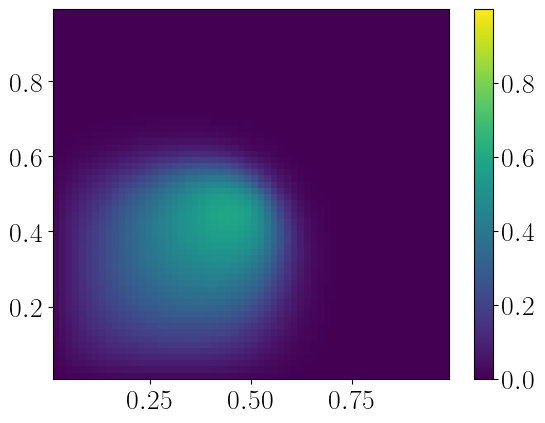

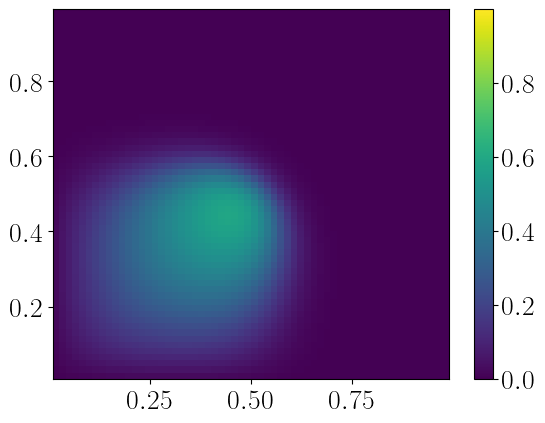

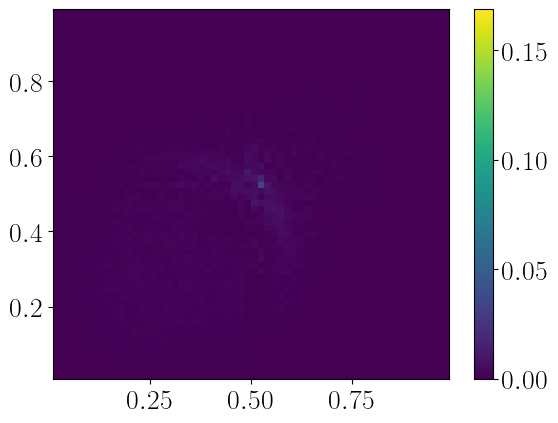

In [68]:
tk    = 198

prefix = rom_figs + f"t{tk}_{rom_str['intr']}{rom_str[intf_comp]}{hr_str}"
error = np.abs(ddfom_data.UU[:ddnmrom_data.UU.shape[0]] - ddnmrom_data.UU)

max_error = 0.16892575216718103 #error.max()

print(f'Max error = {error.max()}')
print(f'argmax k  = {maxk}')

update_frame(tk, ddnmrom_data.UU, umin, umax, '$u(t, x, y)$')
plt.savefig(prefix + "u_state.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

update_frame(tk, ddfom_data.UU, umin, umax, '$u(t, x, y)$')
plt.savefig(fom_figs+f't{tk}_u_state.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

update_frame(tk, error, 0.0, max_error, 'error')
plt.savefig(prefix + f"error_max{max_error:1.3e}.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

## Iteration count histograms


In [69]:
rom_str

{'intr': 'intr_ld4rnz5rs5wd1e-06Swish_',
 'intf': 'intf_ld2rnz5rs5wd1e-06Swish_',
 'port': 'port_ld2rnz5rs5wd1e-06Swish_'}

In [70]:
data_dir2 = data_dir + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/' 
hrfile = data_dir2 + f'mu_{mu}_{rom_str["intr"]}{rom_str[intf_comp]}{hr_str}ithist.p'
file = data_dir2 + f'mu_{mu}_{rom_str["intr"]}{rom_str[intf_comp]}ithist.p'

it_hist = pickle.load(open(file, 'rb'))
it_hist_hr = pickle.load(open(hrfile, 'rb'))

In [71]:
it_hist_hr

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


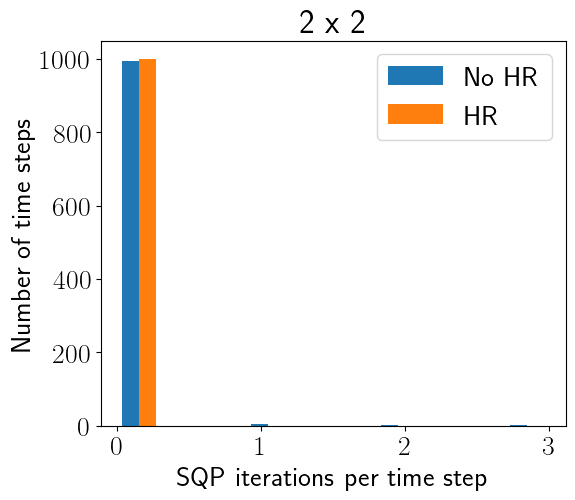

In [72]:
plt.figure(figsize=(6, 5))
plt.hist([it_hist, it_hist_hr], label=['No HR', 'HR'])
plt.xlabel('SQP iterations per time step')
plt.ylabel('Number of time steps')
plt.title(f'{nsub_x} x {nsub_y}')
plt.legend(loc='best')
plt.savefig(rom_figs + f'mu_{mu}_{rom_str["intr"]}{rom_str[intf_comp]}iter_histogram.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Compute residuals

In [22]:
ntr     = ddnmrom_data.UU.shape[0]-1
lam     = np.zeros(ddnmrom.n_constraints)
reshist = np.zeros(ntr)

fomreshist = np.zeros(ntr) 
lamfom  = np.zeros(ddfom.n_constraints)
ht = 2/nt
for i,s in enumerate(ddnmrom.subdomain):
    for k in range(ntr):
        res, jac, H, rhs, Ag, Adg = s.res_jac(ddnmrom_data.subdomain[i].interior.w[k+1], 
                                              ddnmrom_data.subdomain[i].interface.w[k+1],
                                              ddnmrom_data.subdomain[i].interior.w[k],
                                              ddnmrom_data.subdomain[i].interface.w[k],
                                              lam, ht)
        reshist[k] += 0.5*np.dot(res, res)
        
        res, jac, H, rhs, Ax = ddfom.subdomain[i].res_jac(ddfom_data.subdomain[i].interior.u[k+1],
                                                          ddfom_data.subdomain[i].interior.v[k+1],
                                                          ddfom_data.subdomain[i].interface.u[k+1],
                                                          ddfom_data.subdomain[i].interface.v[k+1],
                                                          ddfom_data.subdomain[i].interior.u[k],
                                                          ddfom_data.subdomain[i].interior.v[k],
                                                          ddfom_data.subdomain[i].interface.u[k],
                                                          ddfom_data.subdomain[i].interface.v[k],
                                                          lamfom, ht)
        fomreshist[k] += 0.5*np.dot(res, res)


KeyboardInterrupt: 

In [ ]:
tt = np.linspace(t_lim[0], t_lim[1], nt+1)[0:ntr]
plt.figure(figsize=(8,6))
ls = ['-', '--', '.-', ':']
# plt.semilogy(tt, fomreshist, ls[0], label=f'DD FOM')
plt.semilogy(tt, reshist, ls[1], label=f'DD NM-ROM')
plt.xlabel('$t_k$')
plt.ylabel('$(1/2)\sum_i \|\mathbf{r}_i\|_2^2$')
# plt.ylabel('$\|\mathbf{r}_i(\mathbf{g}_i^\Omega(\widehat{\mathbf{x}}_i^{\Omega(k)}), \mathbf{g}_i^\Gamma(\widehat{\mathbf{x}}_i^{\Gamma (k)}))\|_2$')
plt.legend()
plt.show()

## Sandbox

In [ ]:
ddnmrom_data.u_full.shape

In [ ]:
sp = [i for i,p in enumerate(ddfom.ports) if len(ddfom.port_dict[p])<10]

In [ ]:
idx = np.sort(np.concatenate([ddfom.port_dict[ddfom.ports[i]] for i in sp]))

In [ ]:
np.abs(ddfom_data.u_full[1,idx]-ddnmrom_data.u_full[1, idx])

In [ ]:
tk=0
shift = 4
xl, xr = nx//2-shift, nx//2+shift
yl, yr = ny//2-shift, ny//2+shift 
Xsl = X[xl:xr, yl:yr]
Ysl = Y[xl:xr, yl:yr]
Ufomsl = ddfom_data.UU[tk, xl:xr, yl:yr]
Uromsl = ddnmrom_data.UU[tk, xl:xr, yl:yr]

In [ ]:
plt.clf()
plt.pcolormesh(Xsl, Ysl, Ufomsl, cmap='viridis', shading='auto', vmin=umin, vmax=umax) 
cb = plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
plt.clf()
plt.pcolormesh(Xsl, Ysl, Uromsl, cmap='viridis', shading='auto', vmin=umin, vmax=umax) 
cb = plt.colorbar(orientation='vertical')
plt.savefig(prefix + "u_state_zoom.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
errorsl = np.abs(Ufomsl-Uromsl)
plt.pcolormesh(Xsl, Ysl, errorsl, cmap='viridis', shading='auto', vmin=0, vmax=max_error) 
cb = plt.colorbar(orientation='vertical')
plt.savefig(prefix + f"error_max{max_error:1.3e}_zoom.png", bbox_inches='tight', pad_inches=0.1)
plt.show()